# Final Hurricane Analysis

### If you want to move to Florida and are wondering which county is least likely to get hit by a Hurricane or named storm you came to the right place. 


In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
%matplotlib inline
import pytz
import pandas_montecarlo
import seaborn as sns
from PIL import Image, ImageTk
from opencage.geocoder import OpenCageGeocode
from geopy.geocoders import Nominatim
import plotly.graph_objects as go
import reverse_geocoder as rg
import pprint
import random

geolocator = Nominatim(user_agent="HUR")


sns.set_style('whitegrid')

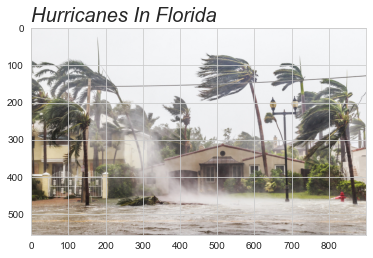

In [2]:
#Hurricane picture
hurricane_pic_path = Path(r"HUR_data/Florida-hurricane-GR.jpg")
hurricane_pic = Image.open(hurricane_pic_path)
plt.title(label = "Hurricanes In Florida"
         ,loc="left" # decide where you want the title
         ,fontsize = 20 # how big you want the titles
         ,fontstyle='italic' # font style...
         )
plt.imshow(hurricane_pic)

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
# Set token using Plotly Express set function
px.set_mapbox_access_token(map_box_api)

## Importing the data

In [4]:
# Reading Landfall prob
landfall_prob = Path("landfall_prob_by_county_50yr.csv")
landfall_df = pd.read_csv(landfall_prob, index_col = 'County')              
landfall_df.sort_index(ascending = True, inplace = True)
# Import geocodes for Florida counties
geocodes = Path("lat_long.csv")
geocodes_df = pd.read_csv(geocodes, index_col = 'County')
geocodes_df.sort_index(ascending = True, inplace = True)
# Import Median Home Prices for Florida counties
median = Path("median_home_value.xlsx")
median_df = pd.read_excel(median, index_col = 'County')              
median_df.sort_index(ascending = True, inplace = True)
# Import all hurricane landfalls from the Atlantic basin CSV to Panda Dataframes
file_path = Path("HUR_data/Subset_HURDAT_reverse_geo.csv")
HUR_data = pd.read_csv(file_path)
# Atlantic Hurricanes data
Atlantic_full_file_path = Path("Fullset_2004_HUR.csv")
Atlantic_full_data = pd.read_csv(Atlantic_full_file_path,parse_dates=['date'],dayfirst=True)
# Andrew data
Andrew_file_path = Path("HUR_data/ANDREW_LAND.csv")
Andrew_data = pd.read_csv(Andrew_file_path)
#Atlantic Data
Atlantic_file_path = Path("HUR_data/historical_losses.csv")
Atlantic_data = pd.read_csv(Atlantic_file_path)
#Import distribution of events
Sim_dist_data=pd.read_csv('HUR_data/MC_Sim_dist.csv')
Sim_dist_df = pd.DataFrame(Sim_dist_data)
#Import historical loss data
Sim_loss_data=pd.read_csv('HUR_data/MC_Sim_inflation.csv')
Sim_loss_df = pd.DataFrame(Sim_loss_data)
#map data 
Map_data=pd.read_csv('HUR_data/MC_Sim_final2.csv')
Map_data_df=pd.DataFrame(Map_data)

## Cleaning the Data

In [5]:
# Change values from string to float, remove $
median_df[median_df.columns[1:]] = median_df[median_df.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
median_df=median_df.drop(columns=["Unnamed: 0","Unnamed: 3","Unnamed: 4"])
median_reset_df = median_df.reset_index()
#Remove blank space from Index in Median Home Values DataFrame
median_reset_df['County'] = median_reset_df['County'].str.strip()
geocodes_reset_df = geocodes_df.reset_index()
landfall_reset_df =landfall_df.reset_index()
# Removing percentage from each column 
landfall_df[landfall_df.columns[1:10]] = landfall_df[landfall_df.columns[1:10]].replace('[\%,]', '', regex=True).astype(float)
#drop the storms that do not make Florida landfall:
Atlantic_full_data_df = pd.DataFrame(Atlantic_full_data)
Atlantic_full_data_df['year'] = pd.DatetimeIndex(Atlantic_full_data_df['date']).year
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'DANIELLE' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'NICOLE' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'UNNAMED' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'IVAN' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'GASTON' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
indexNames = Atlantic_full_data_df[Atlantic_full_data_df['name'] == 'EARL' ].index
Atlantic_full_data_df.drop(indexNames, inplace=True)
Atlantic_full_data_df.dropna(subset =['index'], inplace=True)
Atlantic_data_df = pd.DataFrame(Atlantic_data)



In [45]:
#Merge Median Home Values DataFrame with Geocodes DataFrame
combined_df=geocodes_reset_df.merge(median_reset_df,how='inner',on='County' )
#Merge Median Home Values DataFrame with Landfall probabilities
combined_df_2= pd.concat([landfall_df,geocodes_df],axis=1,join="inner").reset_index()
combined_df_3= pd.concat([landfall_df,median_df],axis=1,join="inner")
combined_df_3=median_reset_df.merge(landfall_reset_df,how='inner',on='County' )

In [33]:
#simulations
iterations = 100000
mean_losses_per_hurricane = Sim_loss_df.mean()
std_dev_losses_per_hurricane = Sim_loss_df.std()
total_losses = []
for i in range(iterations):
    num_hurricanes = np.random.choice(np.arange(0,4), p =[0.54, 0.26, 0.15, 0.05])
    hurricane_loss = np.random.normal(mean_losses_per_hurricane,std_dev_losses_per_hurricane )[0]
    if hurricane_loss < 0:
        hurricane_loss =0.0
    total_loss = num_hurricanes * hurricane_loss
    total_losses.append(total_loss)

#cleaning data for monte carlo
total_losses = np.array(total_losses)
data = pd.DataFrame(total_losses)
Sim_results_df = pd.DataFrame()
Sim_results_df.append(data)
data.astype(float)
Loss_set = data.rename(columns={0: "Sim_Losses"})
Loss_set = Loss_set.sort_values('Sim_Losses',ascending=False).reset_index()
del Loss_set['index']
Loss_set['default_rank'] = Loss_set['Sim_Losses'].rank(ascending=False)
Total_Events = Loss_set['default_rank'].count()+1
Loss_set['EP']= Loss_set['default_rank']/(Total_Events)
Loss_set['Year'] = (1/Loss_set['EP']).round(0)
Loss_set_df = pd.DataFrame(Loss_set)
Loss_set_df['Year'].astype('int')
Loss_set_df['default_rank'].astype('int')
Loss_set_df['EP'].astype('int')
Loss_set_df['Sim_Losses'].astype('int')
EP_curve = Loss_set_df[Loss_set_df.Year == 1000]
filterinfDataframe = Loss_set_df[(Loss_set_df['Year'] == 100001) |
                                  (Loss_set_df['Year'] == 1000) |
                                 (Loss_set_df['Year'] == 500) |
                                 (Loss_set_df['Year'] == 250) |
                                 (Loss_set_df['Year'] == 200) |
                                  (Loss_set_df['Year'] == 100) |
                                 (Loss_set_df['Year'] == 50) |
                                 (Loss_set_df['Year'] == 25) |
                                 (Loss_set_df['Year'] == 10) |
                                 (Loss_set_df['Year'] == 5)|
                                 (Loss_set_df['Year'] == 2) ]
filterinfDataframe.sort_values(by=['Year']).reset_index()
filterinfDataframe['Sim_Losses'].max()
filterinfDataframe.to_csv('MC_Sim_final3.csv')
Map_data_df = pd.DataFrame(Map_data).reset_index()
Map_data_df['Sim_Losses'].astype('int')
Map_data_df['Year'].astype('int')
Hur_data_df = pd.DataFrame(HUR_data)
Hur_data_df['year'] = pd.DatetimeIndex(Hur_data_df['date']).year
Hur_data_df.dropna(subset =['index'], inplace=True)
filterinfDataframe = Hur_data_df[
                                (Hur_data_df['year'] == 2004) |
                               (Hur_data_df['year'] == 2005) ]


Floridamap = filterinfDataframe.filter(regex ='[Florida]')


## Plots for Hurricane Analysis

### Atlantic Bacin Hurricanes 04/05

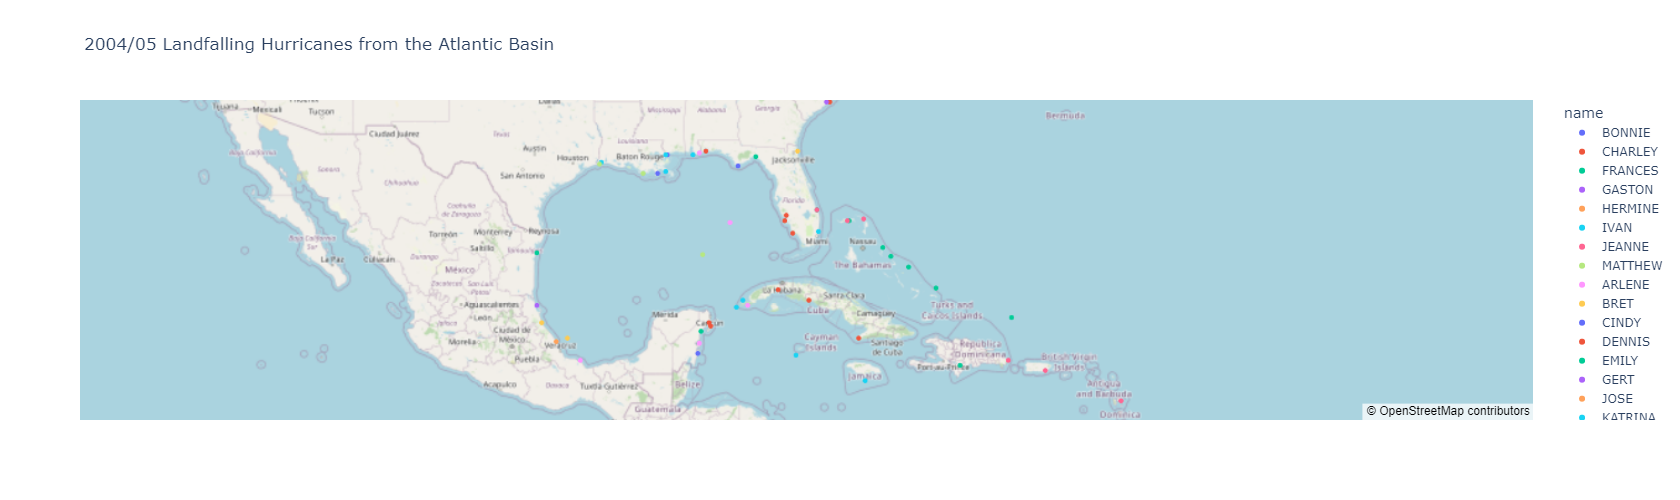

In [35]:
Atlantic_2004_map = px.scatter_mapbox(Floridamap,
    title = "2004/05 Landfalling Hurricanes from the Atlantic Basin",
    lat="latitude",
    lon="longitude",
    hover_name='name',                                 
    zoom = 3.5,
    height = 500,
    color="name",                                  
                                      
)

Atlantic_2004_map.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="manual"
)

Atlantic_2004_map.update_layout(mapbox_style="open-street-map")


### Florida Hurricane Paths 2004

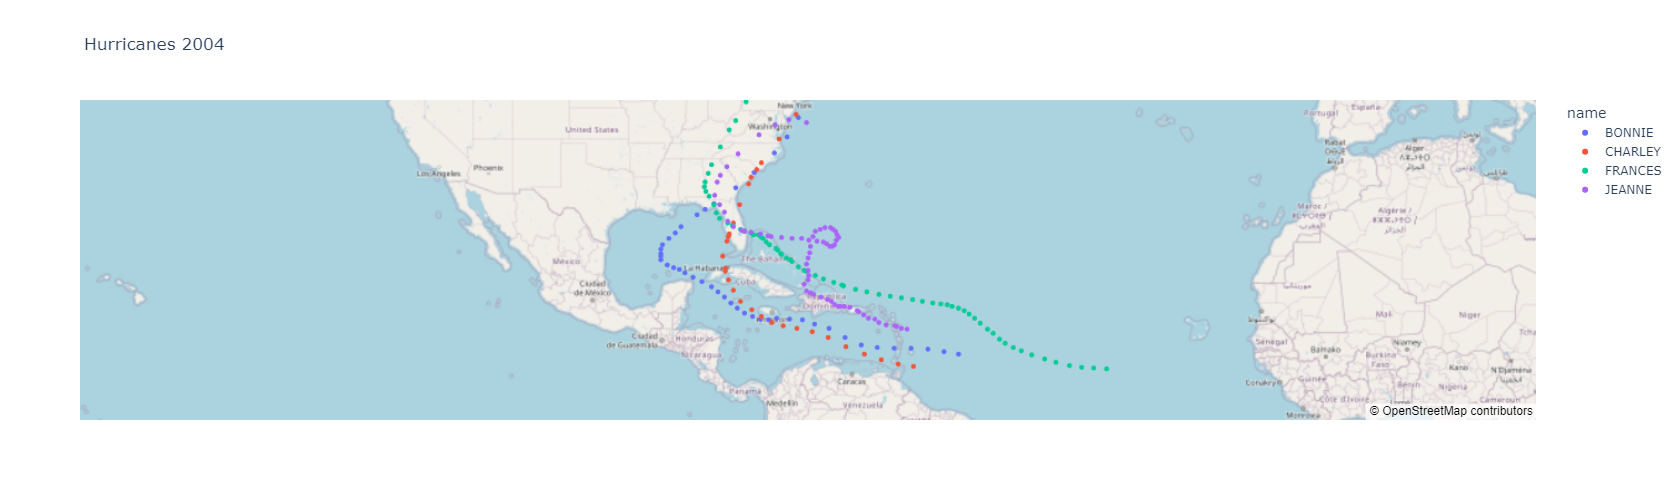

In [50]:

Florida_paths_2004_map = px.scatter_mapbox(Atlantic_full_data_df,
    title = "Hurricanes 2004",
    lat="latitude",
    lon="longitude",
    hover_name='name',                                 
    zoom = 2.5,
    height = 500,
    color="name",
    #groupby="year"                                  
                                      
)

Florida_paths_2004_map.update_layout(mapbox_style="open-street-map")
Florida_paths_2004_map.show()

### Hurricane Andrew Path

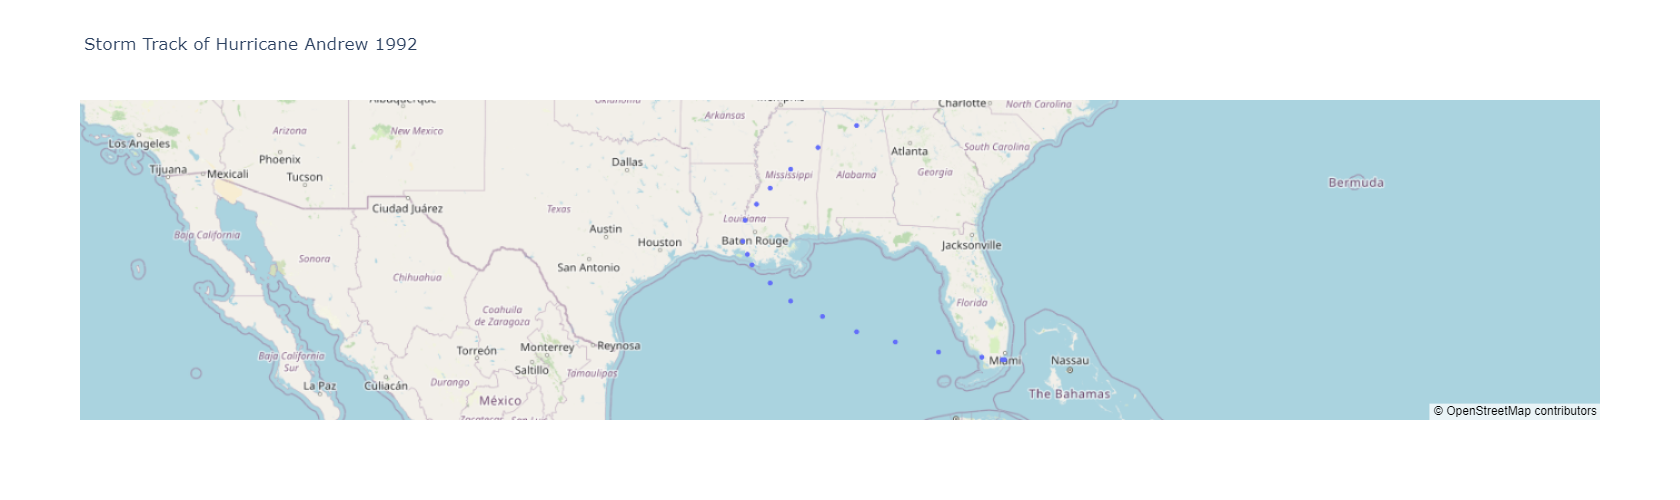

In [14]:
Andrew_map = px.scatter_mapbox(Andrew_data,
    title = "Storm Track of Hurricane Andrew 1992",
    lat="latitude",
    lon="longitude",
    zoom = 4,
    height = 500                              
)


Andrew_map.update_layout(mapbox_style="open-street-map")
Andrew_map.show()

### Expected loses by Year in Billions of $

In [15]:
Map_data_df.hvplot.bar(title = "Expected Losses by Year in $bn",
                                x='Year', y='Sim_Losses' 
                               )

:Bars   [Year]   (Sim_Losses)

### Atlantic Basin Landfalling Hurricanes from 1852-2020

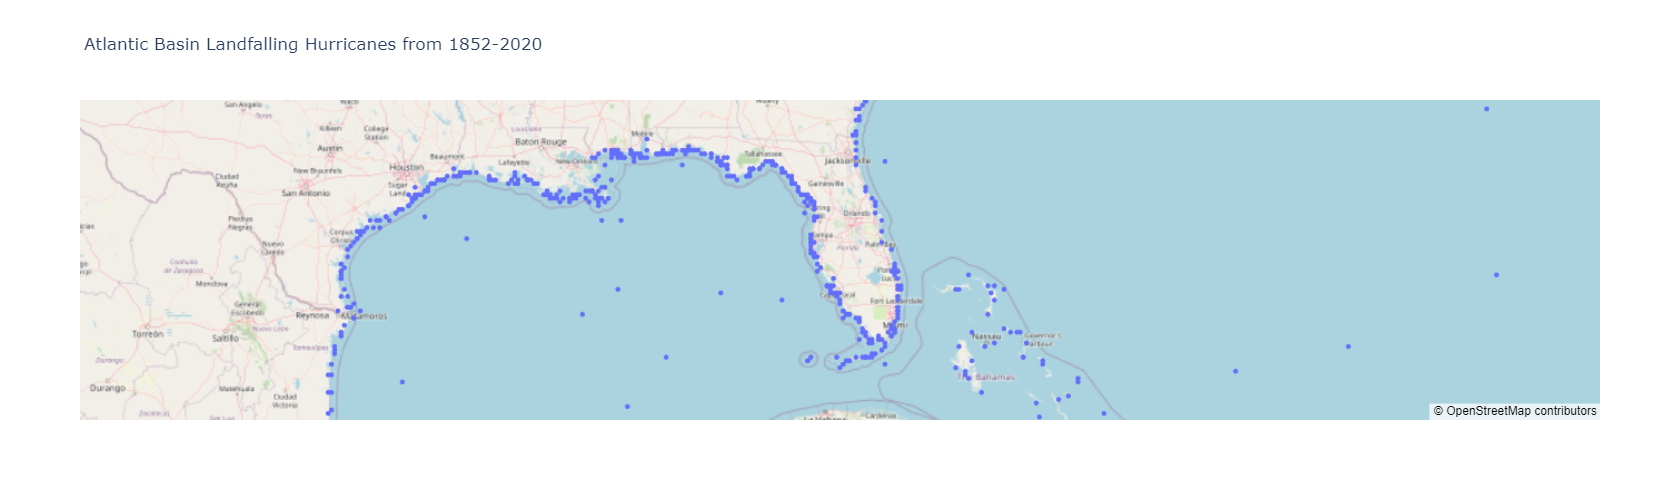

In [16]:

fl_county_map = px.scatter_mapbox(HUR_data,
    title = "Atlantic Basin Landfalling Hurricanes from 1852-2020",
    lat="latitude",
    lon="longitude",
    hover_name='name',                               
    zoom = 4.5,
    height = 500                              
)


fl_county_map.update_layout(mapbox_style="open-street-map")
fl_county_map.show()

### Scatter plot showing Florida median home prices per county in ascending order

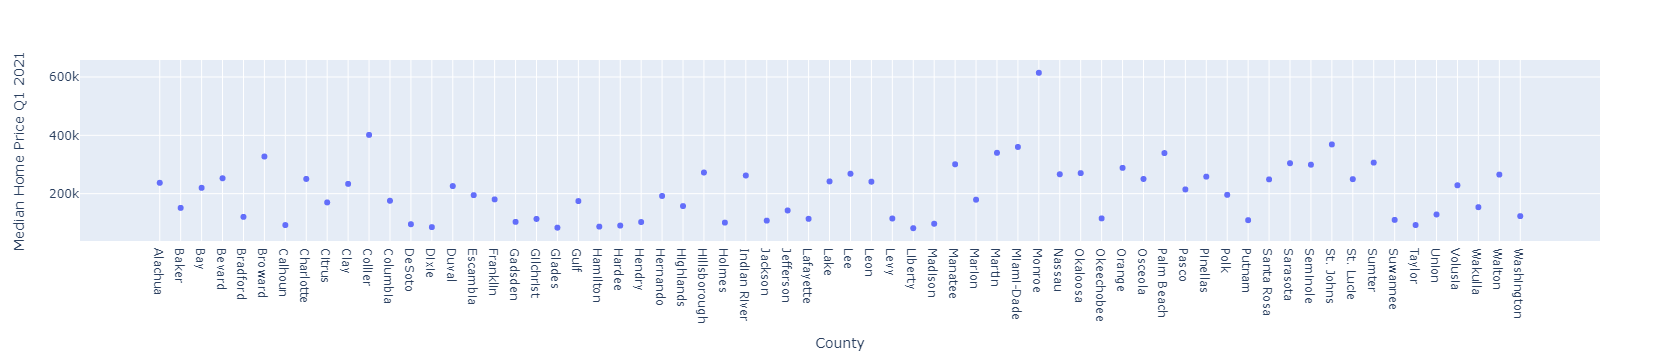

In [17]:
px.scatter(median_reset_df, x="County", y="Median Home Price Q1 2021")

### Probability of Hurricane events by County

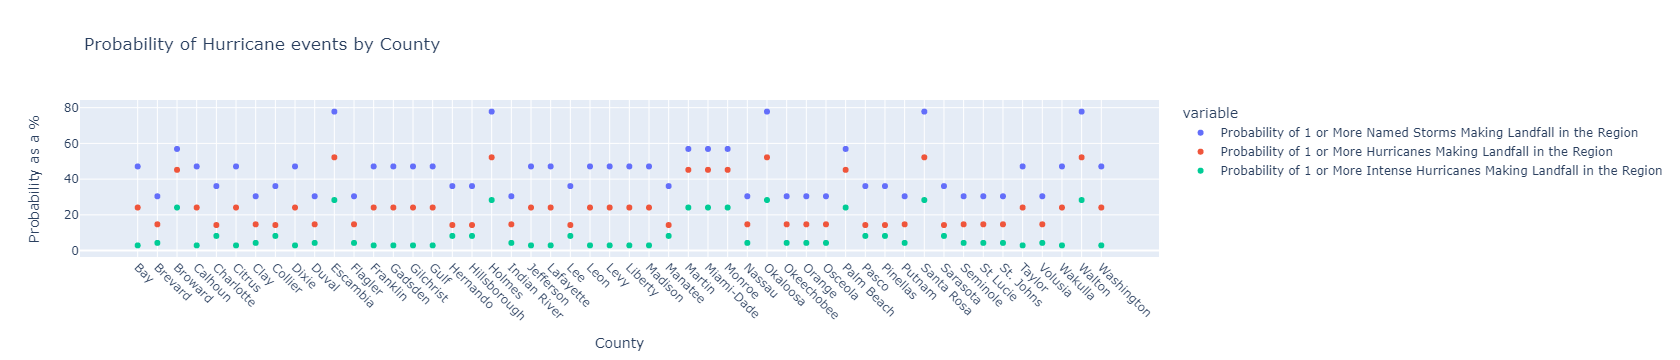

In [18]:
px.scatter(landfall_df,x=landfall_df.index,y=['Probability of 1 or More Named Storms Making Landfall in the Region','Probability of 1 or More Hurricanes Making Landfall in the Region','Probability of 1 or More Intense Hurricanes Making Landfall in the Region']
           ,width=900
           ,title='Probability of Hurricane events by County'
           ,labels={'value':'Probability as a %'}).update_xaxes(tickangle=45)

### Median Home prices by county in Florida Q1 2021

In [19]:
fig = px.scatter_mapbox(combined_df, lat="Lat", lon="Long", color="County", size="Median Home Price Q1 2021", hover_name='Median Home Price Q1 2021', hover_data=['Median Home Price Q1 2021'], zoom=5)
fig.update_layout(mapbox_style="light")
fig.show()

### Florida counties

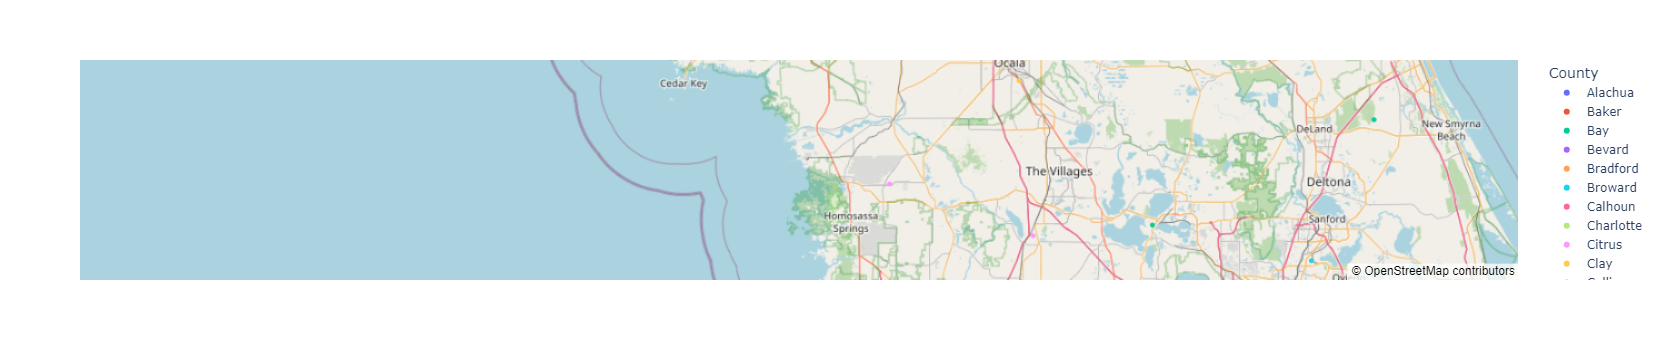

In [20]:
fl_county_map = px.scatter_mapbox(
    geocodes_reset_df,
    lat="Lat",
    lon="Long",
    color="County"
)
fl_county_map.update_layout(mapbox_style="open-street-map")
fl_county_map.show()

### Florida Hurricane Landfall from 1903-2005

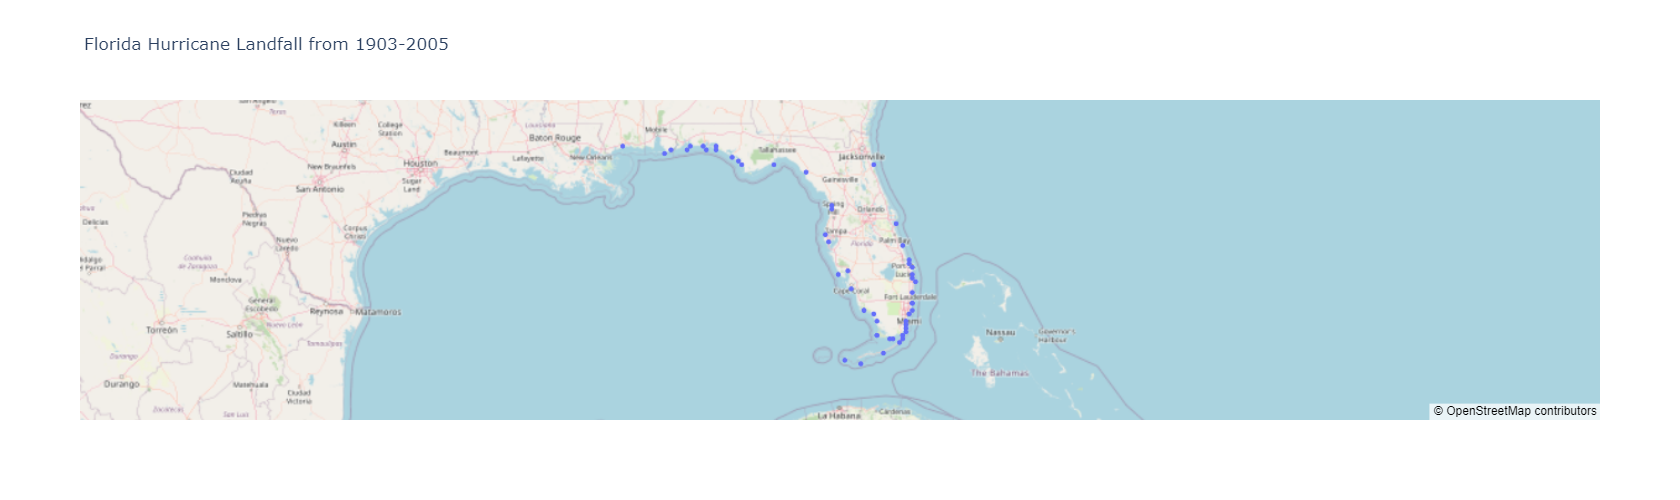

In [21]:
Atlantic_map = px.scatter_mapbox(Atlantic_data,
    title = "Florida Hurricane Landfall from 1903-2005",
    lat="Lat",
    lon="Lon",
    zoom = 4.5,
    height = 500                              
)


Atlantic_map.update_layout(mapbox_style="open-street-map")
Atlantic_map.show()

### Economic Loss of Florida Hurricanes (adjust for 2020$ in Bns)

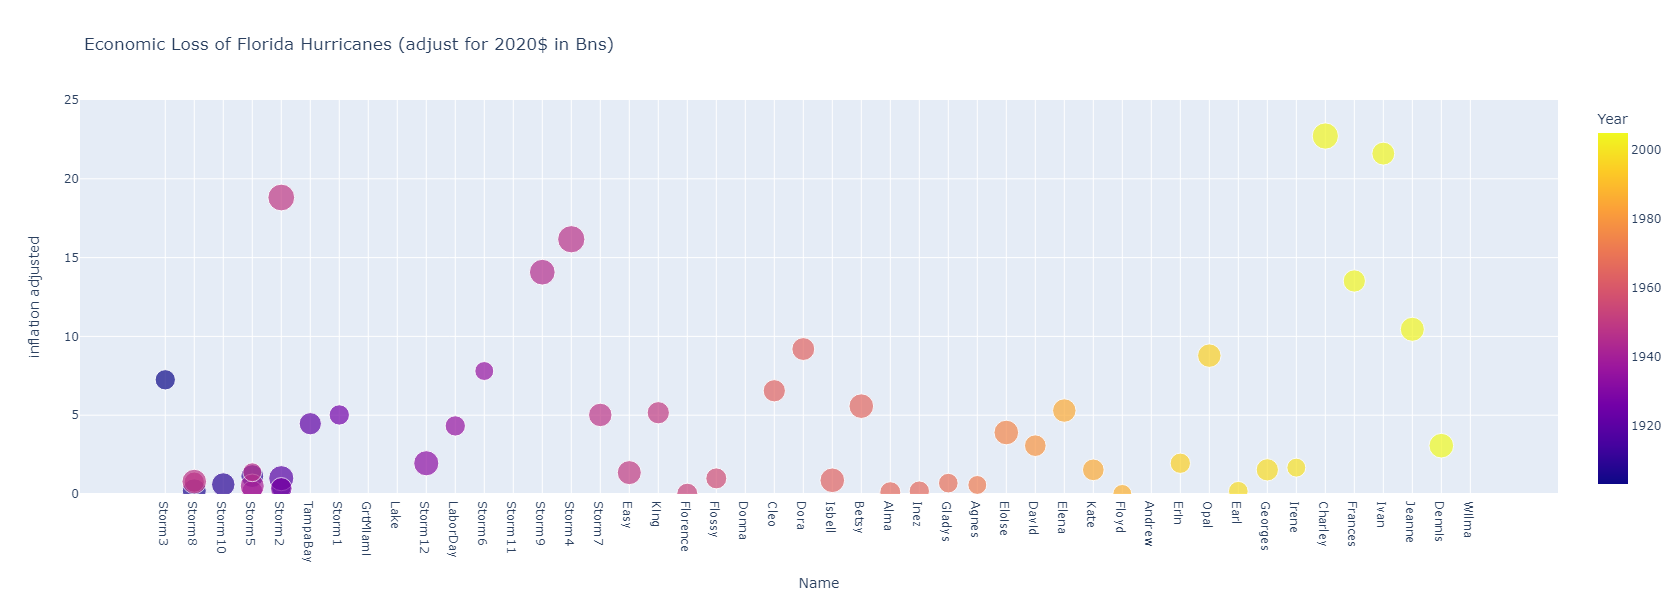

In [22]:
test = px.scatter(Atlantic_data, 
           title="Economic Loss of Florida Hurricanes (adjust for 2020$ in Bns)",
           x="Name",
           y="inflation adjusted",
           size="Wmax",
           color="Year", 
           height=600, 
           width=800)

test.update_layout(yaxis_range=[0,25])

### Exceedence Probability curve

In [31]:
filterinfDataframe.hvplot.line(title = "Exceedence Probability curve",
                                x='EP', y='Sim_Losses' 
                               )

:Curve   [EP]   (Sim_Losses)

### Tropical Storm Landfall Probability in Florida by county

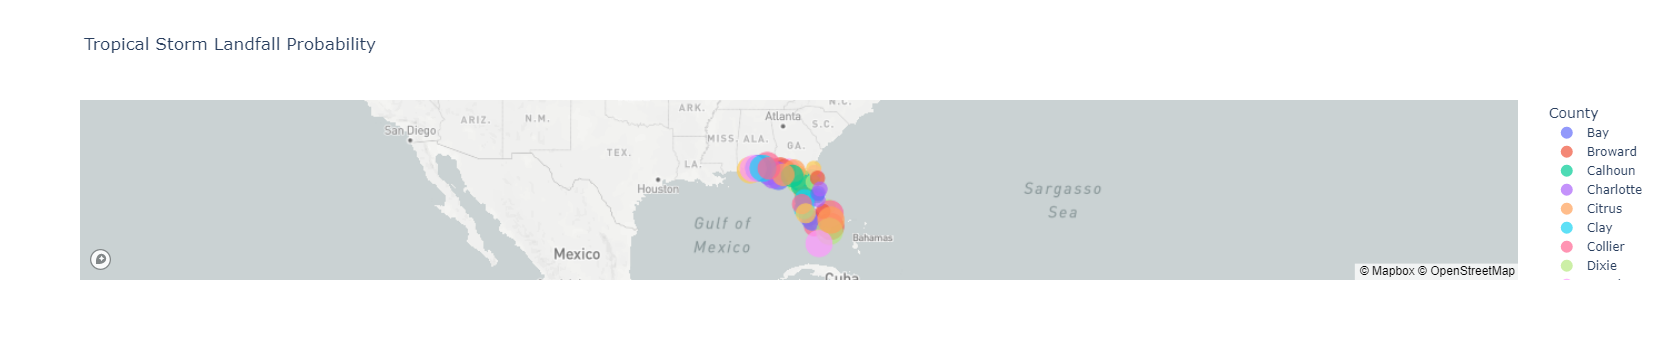

In [39]:
 px.scatter_mapbox(
    combined_df_2,
    lat="Lat",
    lon="Long",
    size="Probability of Tropical Storm-Force (>= 40 mph) Wind Gusts in the County",
    color="County",
    color_continuous_scale=px.colors.cyclical.IceFire,
    title="Tropical Storm Landfall Probability",
    zoom=3,
    width=1000,
)


### Hurricane Landfall Probability in Florida by County

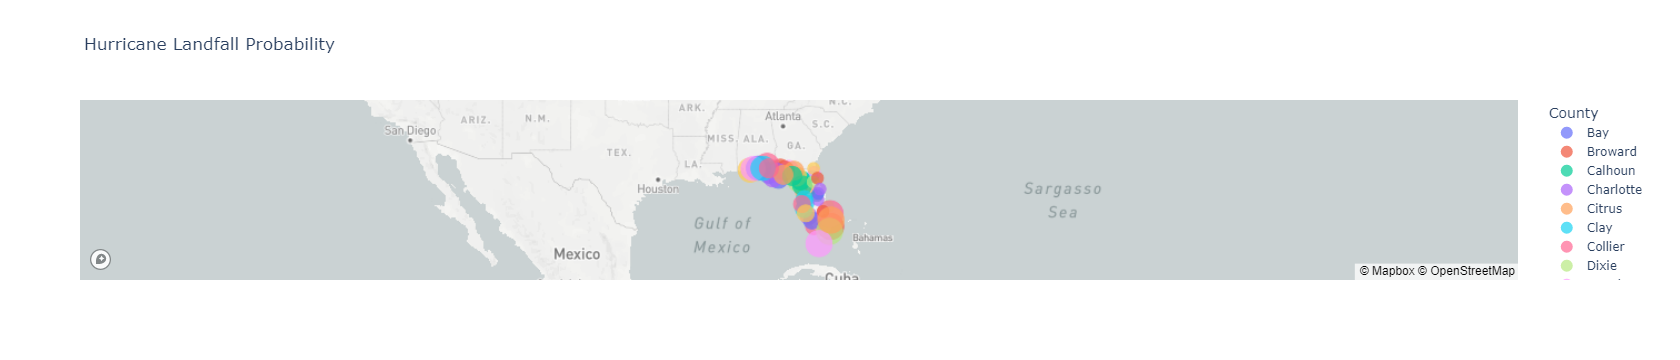

In [40]:
px.scatter_mapbox(
    combined_df_2,
    lat="Lat",
    lon="Long",
    size="Probability of Hurricane-Force (>= 75 mph) Wind Gusts in the County",
    color="County",
    color_continuous_scale=px.colors.cyclical.IceFire,
    title="Hurricane Landfall Probability",
    zoom=3,
    width=1000,
)

### Intense Hurricane Landfall Probability in Florida by county

In [42]:
px.scatter_mapbox(
    combined_df_2,
    lat="Lat",
    lon="Long",
    size="Probability of Intense Hurricane-Force (>= 115 mph) Wind Gusts in the County",
    color="County",
    color_continuous_scale=px.colors.cyclical.IceFire,
    title="Intense Hurricane Landfall Probability",
    zoom=3,
    width=1000,
)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Florida Median Home Value and Tropical Storm Landfall Correlation

In [47]:
combined_df_3.hvplot.scatter(
    x="Probability of Tropical Storm-Force (>= 40 mph) Wind Gusts in the County",
    y="Median Home Price Q1 2021",
    title="Florida Median Home Value and Tropical Storm Landfall Correlation",
    width=1000,
).opts(yformatter="%.0f")

:Scatter   [Probability of Tropical Storm-Force (>= 40 mph) Wind Gusts in the County]   (Median Home Price Q1 2021)

### Florida Median Home Value and Hurricane Landfall Correlation

In [48]:
combined_df_3.hvplot.scatter(
    x="Probability of Hurricane-Force (>= 75 mph) Wind Gusts in the County",
    y="Median Home Price Q1 2021",
    title="Florida Median Home Value and Hurricane Landfall Correlation",
    width=1000,
).opts(yformatter="%.0f")

:Scatter   [Probability of Hurricane-Force (>= 75 mph) Wind Gusts in the County]   (Median Home Price Q1 2021)

### Florida Median Home Value and Intense Hurricane Landfall Correlation

In [49]:
combined_df_3.hvplot.scatter(
    x="Probability of Intense Hurricane-Force (>= 115 mph) Wind Gusts in the County",
    y="Median Home Price Q1 2021",
    title="Florida Median Home Value and Intense Hurricane Landfall Correlation",
    width=1000,
).opts(yformatter="%.0f")

:Scatter   [Probability of Intense Hurricane-Force (>= 115 mph) Wind Gusts in the County]   (Median Home Price Q1 2021)